##### useful code

df.dropna(axis=1) # Drops all columns that contain null values.
df.dropna(axis=1,thresh=n) # Drops all rows that have less than n non null values

##### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

##### Load data

In [2]:
cont = pd.read_csv('../data/continents.csv', index_col=1, sep=";").dropna()
#cont.index.name = 'country'
cont = cont.reset_index()
cont['country'] = cont['country'].replace('Burkina', 'Burkina Faso')

In [3]:
#cont

In [4]:
life = pd.read_excel('../data/gapminder_lifeexpectancy.xlsx', index_col=0).dropna()
life.index.name = 'country'
life = life.reset_index()
life = life.melt(id_vars='country', var_name='year', value_name='life_expectancy')

In [5]:
pop = pd.read_excel('../data/gapminder_population.xlsx', index_col=0).dropna()
pop.index.name = 'country'
pop = pop.reset_index()
pop = pop.melt(id_vars='country', var_name='year', value_name='population')
pop['population']=pop['population']/1000
pop

,country,year,population
0,Afghanistan,1800,3280.000
1,Albania,1800,410.445
2,Algeria,1800,2503.218
3,American Samoa,1800,8.170
4,Andorra,1800,2.654
...,...,...,...
18544,Virgin Islands (U.S.),2015,106.291
18545,Yemen,2015,26832.215
18546,Zambia,2015,16211.767
18547,Zimbabwe,2015,15602.751


In [6]:
fert = pd.read_csv('../data/gapminder_total_fertility.csv', index_col=0).dropna()
fert.index.name = 'country'
fert.columns = fert.columns.astype(int)
fert = fert.reset_index()
fert = fert.melt(id_vars='country', var_name='year', value_name='fertility_rate')

##### Combine tables

In [7]:
#print(combo.columns)


In [8]:
import warnings
warnings.filterwarnings('ignore')

combo=life.merge(fert, how = "outer", on = ["country", "year"])
combo=combo.merge(pop, how = "outer", on = ["country", "year"])
warnings.resetwarnings()

combo = combo.dropna()

# add continents
combo = combo.merge(cont, how = "outer", on = "country")
combo = combo.dropna()



In [9]:
comment='''

This is a construction site. the everages will have to be calculated year by year.
'''

import numpy as np

def weighted_mean_life_expectancy(group):
    return np.average(group['life_expectancy'], weights=group['population'])

def weighted_mean_fertility_rate(group):
    return np.average(group['fertility_rate'], weights=group['population'])

combo_continents = combo.groupby(['continent', 'year']).apply(lambda g: pd.Series({
    'life_expectancy': weighted_mean_life_expectancy(g),
    'fertility_rate': weighted_mean_fertility_rate(g),
    'population': g['population'].sum()
})).reset_index()

#combo_continents

In [10]:
# find out which countries are missing

#combo[combo['country']=='Germany']
#combo2
#combo_incomplete = combo2[combo2.isna().sum(axis=1) > 0]
#combo_incomplete
#no_continent = combo_incomplete[combo_incomplete['continent'].isna()]['country'].tolist()
#combo_incomplete[combo_incomplete['continent'].isna()]['country'].drop_duplicates()



##### Main graph

In [11]:
#combo_This['color'].value_counts(dropna=False)
#print(combo_This.columns)


In [12]:
#!pip install geopandas
#!pip install descartes
import geopandas as gpd
import descartes
warnings.filterwarnings('ignore')

In [13]:
#bubble_colors_ugly = [['Africa', 'Europe', 'Asia', 'North America', 'South America', 'Australia and Oceania'],
#                  ['blue', 'green', 'orange', 'red', 'pink', 'magenta']]

bubble_colors = [['Africa', 'Europe', 'Asia', 'North America', 'South America', 'Australia and Oceania'],
#                 ['darkblue', 'limegreen', 'gold', 'crimson', 'cyan', 'black']]
                 ['blue', 'green', 'orange', '#8B0000', '#FF7F7F', 'purple']]

color_dict = dict(zip(bubble_colors[0], bubble_colors[1]))
combo_continents['color'] = combo_continents['continent'].map(color_dict)
combo['color'] = combo['continent'].map(color_dict)

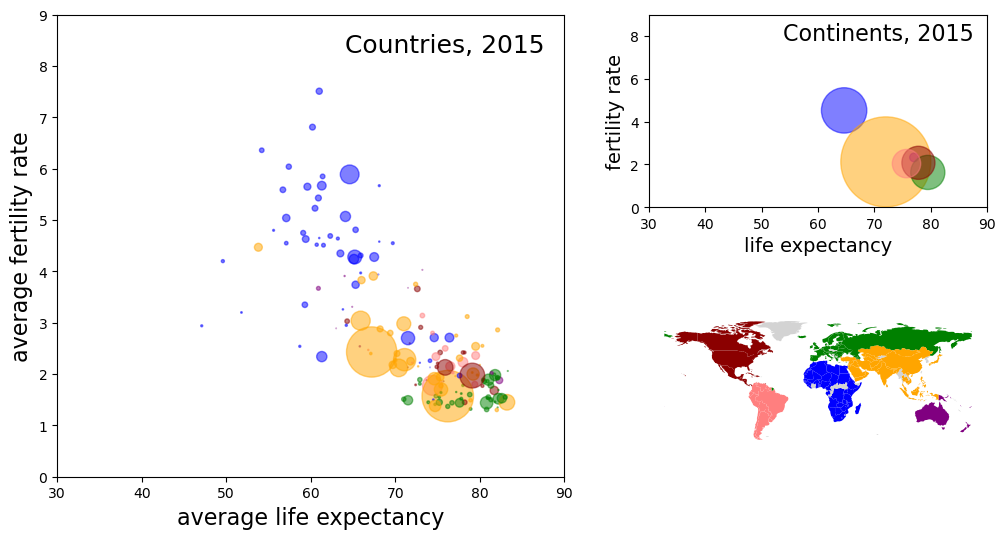

In [19]:
from IPython.display import clear_output  # import the clear_output function
import time

for current_year in range(1960, 2016):

    combo_This = combo[combo['year'] == current_year]
    combo_continents_This = combo_continents[combo_continents['year'] == current_year]

    fig = plt.figure(figsize=(12,6))

    # Define subplots based on gridspec
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(2, 2, width_ratios=[3, 2])
    gs.update(hspace=.4)  # adjust the vertical spacing between subplots
    ax1 = plt.subplot(gs[:, 0])   ## main map, on the left, bubbbles for each country
    ax2 = plt.subplot(gs[0, 1])   ## map on the upper reight, bubbles for each continent
    ax3 = plt.subplot(gs[1, 1])   ## map on the lower right, world map, kind of as legend for the bubble colors

    # map 1 of 3
    ax1.scatter(combo_This['life_expectancy'], combo_This['fertility_rate'], 
                s=combo_This['population']/1000, c=combo_This['color'], alpha=0.5)
    ax1.set_xlim([30, 90])
    ax1.set_ylim([0, 9])
    ax1.text(.96, .96, "Countries, " + str(current_year), fontsize=18, ha='right', va='top', transform=ax1.transAxes) 
    ax1.set_xlabel("average life expectancy", fontsize=16)
    ax1.set_ylabel("average fertility rate", fontsize=16)

    # map 2 of 3
    ax2.scatter(combo_continents_This['life_expectancy'], combo_continents_This['fertility_rate'], 
                s=combo_continents_This['population']/1000, c=combo_continents_This['color'], alpha=0.5)
    ax2.set_xlim([30, 90])
    ax2.set_ylim([0, 9])
    ax2.text(.96, .96, "Continents, " + str(current_year), fontsize=16, ha='right', va='top', transform=ax2.transAxes) 
    ax2.set_xlabel("life expectancy", fontsize=14)
    ax2.set_ylabel("fertility rate", fontsize=14)


    # Load the world map
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name != "Antarctica")]

    # Rename 'name' column in 'world' to 'country', so that they can be merged.
    world.rename(columns={"name": "country"}, inplace=True)

    # Merge the GeoDataFrame and the color-coded DataFrame
    world = world.merge(combo_This, on="country", how="left")

    # Add some missing colors. With a little help from ChatGPT, I am filling a few of the largest gaps.
    # To make sur i don't have to go in here each time I chage the color definitions above, 
    # I rather copy the color from countries on the same continent. The whole operation is a very bad quick fix.
    add_colors = pd.DataFrame({
        'missing_country': ['W. Sahara', 'United States of America', 'Dem. Rep. Congo', 'Dominican Rep.', 'Russia'],
        'reference_country': ['Egypt', 'Canada', 'Egypt', 'Mexico', 'France']
        })
    def replace_color(row):
        # Get the color of the reference country
        ref_color = world.loc[world['country'] == row['reference_country'], 'color'].values[0]
        # Set the color of the missing country to the color of the reference country
        world.loc[world['country'] == row['missing_country'], 'color'] = ref_color
    add_colors.apply(replace_color, axis=1)


    ax3.set_aspect('equal')

    for _, row in world.iterrows():
        color = row['color']
        if pd.isnull(color):  # If color is NaN, set a default color
            color = 'lightgray'
        gpd.GeoSeries(row['geometry']).plot(ax=ax3, color=color)

    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.spines['bottom'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.axis('off')

    # plot 
    plt.tight_layout()
    
    Save_Mode_On = True
    
    clear_output(wait=True)

    
    if Save_Mode_On:
        file_name = '../out_images/frame_'+str(current_year)
        plt.savefig(file_name, dpi=300)

    plt.show()


In [ ]:
# Get a list of countries without a color
#countries_without_color = world[world['color'].isna()]['country']

# Print the list of countries
#print(countries_without_color)


##### get the numbers per continent

##### Animation

In [20]:
import imageio

if Save_Mode_On:
    
    image_series = []

    for i in range(1944, 2032):
        if i < 1960:      # add a few 1960 frames at the beginning
            j = 1960
        elif i > 2015:    # add a few 2015 frames at the end
            j = 2015
        else:
            j = i
        filename = f'../out_images/frame_{j}.png'
        image_series.append(imageio.imread(filename))

    imageio.mimsave('../out_images/Animated_Scatterplot.gif', image_series, fps=5)
